In [4]:
import numpy as np
# import pandas as pd
import os
# import cv2
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
import tensorflow as tf
import PIL.Image
from tensorflow.keras import layers, models

2024-06-07 12:29:53.602370: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 12:29:54.724805: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Test and configure GPU

In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
else:
    print('No GPUs detected')

1 Physical GPUs, 1 Logical GPUs


2024-06-07 12:29:56.226536: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-07 12:29:56.298355: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-07 12:29:56.298414: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-07 12:29:56.303937: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-07 12:29:56.304030: I external/local_xla/xla/stream_executor

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
meta_path = "cov_data/metadata.csv"
data_path = "cov_data"

Can discard metadata? Labels are determined by folders (covid/pneum/normal).
Can try merging normal and pneum.

In [8]:
img_height = 224
img_width = 224

In [9]:
def load_data_tf(data_path: str, img_shape=(img_height,img_width), batch_size: int=64):
    train_ds,val_ds = tf.keras.utils.image_dataset_from_directory(
        data_path,
        validation_split=0.2,
        subset="both",
        label_mode='categorical',
        seed=123,
        image_size=img_shape,
        batch_size=batch_size)
    return train_ds, val_ds

In [10]:
train_ds, val_ds = load_data_tf('cov_data')

Found 4575 files belonging to 3 classes.
Using 3660 files for training.
Using 915 files for validation.


tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)


2024-06-07 12:30:14.225729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


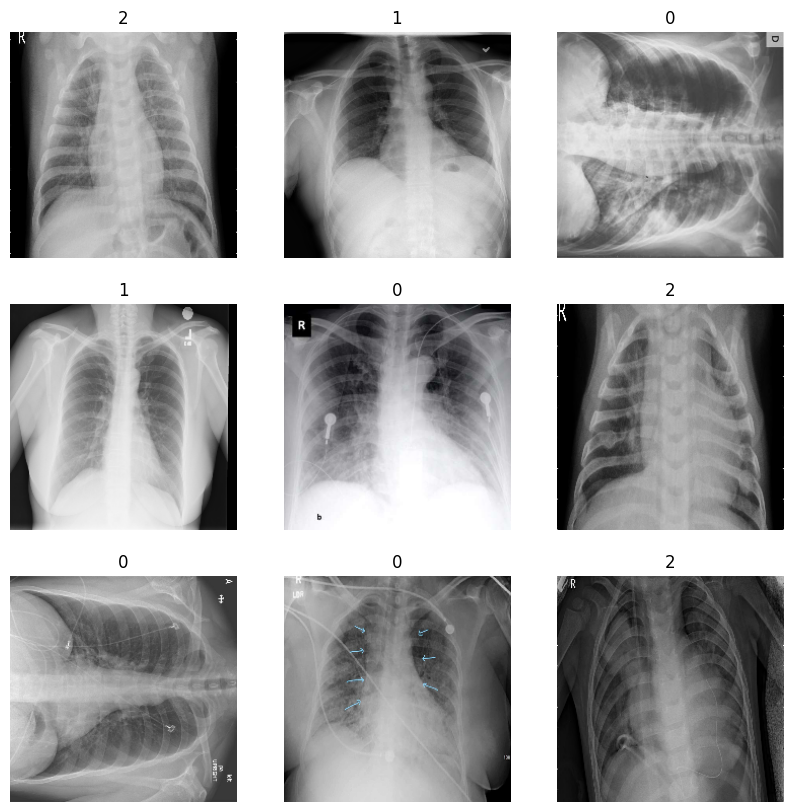

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(tf.math.argmax(labels[i])))
    print(labels[i])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64, 3)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

THE ATTENTION MODEL. HANDLE WITH CARE - MAY CAUSE COMPUTER TO EXPLODE VIOLENTLY

In [19]:
from keras import backend as K

# ATTENTION MODEL

''' FIRST CONV BLOCK '''
l_input = layers.Input(shape=(img_height,img_width,3))
l_norm = tf.keras.layers.Rescaling(1./255) (l_input)
conv_1_1 = layers.Conv2D(filters=64,kernel_size=3,activation='relu',padding='same', name='conv_1_1') (l_norm)
# bn_1_1 = layers.BatchNormalization() (conv_1_1)
conv_1_2 = layers.Conv2D(filters=64,kernel_size=3,activation='relu',padding='same', name='conv_1_2') (conv_1_1)
# bn_1_2 = layers.BatchNormalization() (conv_1_2)
drop_1 = layers.Dropout(rate=0.2, name='drop_1') (conv_1_2)

# this gets passed on to the attention mechanism
l_dense_con_1 = layers.Dense(units=64, activation=None,name='conn_1')(drop_1)

pool_1 = layers.MaxPooling2D(pool_size=(2,2),name='pool_1') (drop_1)

''' SECOND CONV BLOCK '''
conv_2_1 = layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same', name='conv_2_1') (pool_1)
bn_2_1 = layers.BatchNormalization() (conv_2_1)
conv_2_2 = layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same', name='conv_2_2') (bn_2_1)
bn_2_2 = layers.BatchNormalization() (conv_2_2)
drop_2 = layers.Dropout(rate=0.2,name='drop_2') (bn_2_2)

l_dense_con_2 = layers.Dense(units=64, activation=None,name='conn_2')(drop_2)

pool_2 = layers.MaxPooling2D(pool_size=(2,2),name='pool_2') (drop_2)

''' THIRD CONV BLOCK '''
conv_3_1 = layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same',name='conv_3_1') (pool_2)
bn_3_1 = layers.BatchNormalization() (conv_3_1)
conv_3_2 = layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same',name='conv_3_2') (bn_3_1)
bn_3_2 = layers.BatchNormalization() (conv_3_2)
drop_3 = layers.Dropout(rate=0.2,name='drop_3') (bn_3_2)

l_dense_con_3 = layers.Dense(units=64, activation=None,name='conn_3')(drop_3)

pool_3 = layers.MaxPooling2D(pool_size=(2,2),name='pool_3') (drop_3)

''' FINAL CONV BLOCK, GIVES THE FINAL REPRESENTATION (g) '''
conv_4_1 = layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same',name='conv_4_1') (pool_3)
bn_4_1 = layers.BatchNormalization() (conv_4_1)
pool_4_2 = layers.MaxPooling2D(pool_size=(2,2),name='pool_4_2') (bn_4_1)

flat_g = layers.Flatten(name='flat_g') (pool_4_2)
drop_g = layers.Dropout(rate=0.4,name='drop_g') (flat_g)
g = layers.Dense(units=64,activation='relu',name='g') (drop_g)

""" Calculate compatibility scores """
# dot product of l_i's and g
c_1 = layers.Lambda(lambda lam: K.squeeze(K.map_fn(fn=lambda xy: K.dot(xy[0], xy[1]), elems=(lam[0], K.expand_dims(lam[1], -1)), dtype=tf.float32), 3)
                    , name='cdp1',
                    output_shape=(l_dense_con_1.shape[0], l_dense_con_1.shape[1]*l_dense_con_1.shape[2], 1)
                    )([l_dense_con_1, g])
flat_1 = layers.Flatten() (c_1)
act_1 = layers.Softmax() (flat_1)
c_2 = layers.Lambda(lambda lam: K.squeeze(K.map_fn(fn=lambda xy: K.dot(xy[0], xy[1]), elems=(lam[0], K.expand_dims(lam[1], -1)), dtype=tf.float32), 3),
                    name='cdp2',
                    output_shape=(l_dense_con_2.shape[0], l_dense_con_2.shape[1]*l_dense_con_2.shape[2], 1)
                    )([l_dense_con_2, g])
flat_2 = layers.Flatten() (c_2)
act_2 = layers.Softmax() (flat_2)
c_3 = layers.Lambda(lambda lam: K.squeeze(K.map_fn(fn=lambda xy: K.dot(xy[0], xy[1]), elems=(lam[0], K.expand_dims(lam[1], -1)), dtype=tf.float32), 3),
                    name='cdp3',
                    output_shape=(l_dense_con_3.shape[0], l_dense_con_3.shape[1]*l_dense_con_3.shape[2], 1)
                    )([l_dense_con_3, g])
flat_3 = layers.Flatten() (c_3)
act_3 = layers.Softmax() (flat_3)

rs_1 = layers.Reshape((-1,64)) (l_dense_con_1)
g_a_1 = layers.Lambda(lambda lam: K.squeeze(K.batch_dot(K.expand_dims(lam[0], 1), lam[1]), 1), 
             name='ga1',output_shape=(l_dense_con_1.shape[0], 64))([act_1,rs_1])

rs_2 = layers.Reshape((-1,64)) (l_dense_con_2)
g_a_2 = layers.Lambda(lambda lam: K.squeeze(K.batch_dot(K.expand_dims(lam[0], 1), lam[1]), 1), 
             name='ga2',output_shape=(l_dense_con_2.shape[0], 64))([act_2,rs_2])

rs_3 = layers.Reshape((-1,64)) (l_dense_con_3)
g_a_3 = layers.Lambda(lambda lam: K.squeeze(K.batch_dot(K.expand_dims(lam[0], 1), lam[1]), 1), 
             name='ga3',output_shape=(l_dense_con_3.shape[0], 64))([act_3,rs_3])

l_concat = layers.Concatenate() ([g_a_1, g_a_2, g_a_3]) # concatenate the three attention outputs
l_dense_out = layers.Dense(units = 3, activation='softmax') (l_concat)

model_att = models.Model(inputs=l_input, outputs=l_dense_out)
model_att.save_weights('model_att_init_weights.weights.h5')

model_att.summary()
tf.keras.utils.plot_model(model_att, 'model_att.png', show_shapes=True)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 224, 224,  │          0 │ input_layer_5[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1_1 (Conv2D)   │ (None, 224, 224,  │      1,792 │ rescaling_5[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1_2 (Conv2D)   │ (None, 224, 224,  │     36,928 │ conv_1_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_1 (Dropout)    │ (None, 224, 224,  │          0 │ conv_1_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool_1              │ (None, 112, 112,  │          0 │ drop_1[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2_1 (Conv2D)   │ (None, 112, 112,  │     18,464 │ pool_1[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv_2_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2_2 (Conv2D)   │ (None, 112, 112,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv_2_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_2 (Dropout)    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool_2              │ (None, 56, 56,    │          0 │ drop_2[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3_1 (Conv2D)   │ (None, 56, 56,    │     18,496 │ pool_2[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv_3_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv_3_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_3 (Dropout)    │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 973,699 (3.71 MB)

 Trainable params: 973,187 (3.71 MB)

 Non-trainable params: 512 (2.00 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [20]:
model_att.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [21]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

history_att = model_att.fit(train_ds, epochs=50, callbacks=callback,
                    validation_data=val_ds) 

Epoch 1/50


AttributeError: Exception encountered when calling Lambda.call().

[1mmodule 'keras.api.backend' has no attribute 'squeeze'[0m

Arguments received by Lambda.call():
  • inputs=['tf.Tensor(shape=(None, 56, 56, 64), dtype=float32)', 'tf.Tensor(shape=(None, 64), dtype=float32)']
  • mask=['None', 'None']
  • training=True

In [18]:
model = models.Sequential()))
model.add(layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu',input_shape=(256,256,3)))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 125, 125, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 123, 123, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 61, 61, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 61, 61, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 59, 59, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 59, 59, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 57, 57, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 57, 57, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 207936)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │     6,653,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,723,843 (25.65 MB)

 Trainable params: 6,723,843 (25.65 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [21]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

history = model.fit(train_ds, epochs=15, 
                    validation_data=val_ds, callbacks=[callback]) 

Epoch 1/15


I0000 00:00:1717086594.799524   10288 service.cc:145] XLA service 0x7ff6600059f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717086594.799588   10288 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-05-30 18:29:54.936088: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-30 18:29:55.282928: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-05-30 18:29:59.631952: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 532.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-30 18:30:04.537932: W external/local_tsl/tsl/framework/bfc_allo

58/58 ━━━━━━━━━━━━━━━━━━━━ 48s 408ms/step - auc: 0.4891 - categorical_accuracy: 0.3311 - loss: 238.7446 - precision: 0.3066 - recall: 0.1094 - val_auc: 0.5016 - val_categorical_accuracy: 0.3169 - val_loss: 1.0987 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - auc: 0.5020 - categorical_accuracy: 0.3392 - loss: 1.0986 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.5016 - val_categorical_accuracy: 0.3169 - val_loss: 1.0987 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - auc: 0.5020 - categorical_accuracy: 0.3392 - loss: 1.0986 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.5016 - val_categorical_accuracy: 0.3169 - val_loss: 1.0988 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - auc: 0.5018 - categorical_accuracy: 0.3392 - loss: 1.0986 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.